# Предварительное ознакомление с данными, составление плана, подготовка вопросов

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import plotly.express as ps

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
import phik
import optuna
import catboost 
import shap

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind

RS = np.random.seed(240423)

## Содержание:

* [EDA](#eda)
* [Предобработка](#preprcoc)
* [Моделирование](#modelling)
    - [Dummy](#dummy)
    - [Ridge](#linreg)
    - [Forest](#forest)
    - [Catboost](#catboost)
    - [Тест](#test)
* [Отчет](#report)

## 1. EDA <a class="anchor" id="eda"></a>

Первоначально необходимо определиться, с какими данными мы работаем, определелить характер этих данных, установить качество этих данных (аномалии, пропуски и тд)

In [6]:
path = r'./final project'
try:
    #данные об электродах
    electrods = pd.read_csv(rf'{path}/data_arc_new.csv')
    #данные о подаче сыпучих материалов (объём)
    loose_volume = pd.read_csv(rf'{path}/data_bulk_new.csv')
    #данные о подаче сыпучих материалов (время)
    loose_time = pd.read_csv(rf'{path}/data_bulk_time_new.csv')
    #данные о продувке сплава газом
    gas = pd.read_csv(rf'{path}/data_gas_new.csv')
    #результаты измерения температуры
    temperature = pd.read_csv(rf'{path}/data_temp_new.csv')
    #данные о проволочных материалах (объём
    wire_volume = pd.read_csv(rf'{path}/data_wire_new.csv')
    #данные о проволочных материалах (время)
    wire_time = pd.read_csv(rf'{path}/data_wire_time_new.csv')
except FileNotFoundError:
    print('Check the path')
    

In [7]:
dataframes = [electrods, loose_volume, loose_time, gas, temperature, wire_volume, wire_time]

In [8]:
#переименование колонок
def rename_cols(df):
    names = [re.sub(' ', '_', col).lower() for col in df.columns]
    return names

In [9]:
for df in dataframes:
    df.columns = rename_cols(df)

In [10]:
def check_dataframe(df):
    """
    :::Функция печатает статистические показатели
    :::информацию о типах данных, число пропусков
    """
    
    print('Статистические показатели')
    print(df.describe())
    print('--'*30)
    print('--'*30)
    print()
    print('Информация о датасете')
    print(df.info())
    print('--'*30)
    print('--'*30)
    print()
    print('Пропуски в датасете, %')
    print(df.isna().mean() * 100)

#### Электроды

In [11]:
#проверяем общую информацию
check_dataframe(electrods)

Статистические показатели
                key  активная_мощность  реактивная_мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284
------------------------------------------------------------
------------------------------------------------------------

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  1

Мы можем заметить наличие отрицательных значений в реактивной мощности. Это значение слишком велико по модулю и значительно выделяется от прочих значений в статистиках. Это следует проверить по графикам

In [12]:
#Переведем значения в timestamp
electrods['начало_нагрева_дугой'] = pd.to_datetime(electrods['начало_нагрева_дугой'])
electrods['конец_нагрева_дугой'] = pd.to_datetime(electrods['конец_нагрева_дугой'])

In [13]:
electrods

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


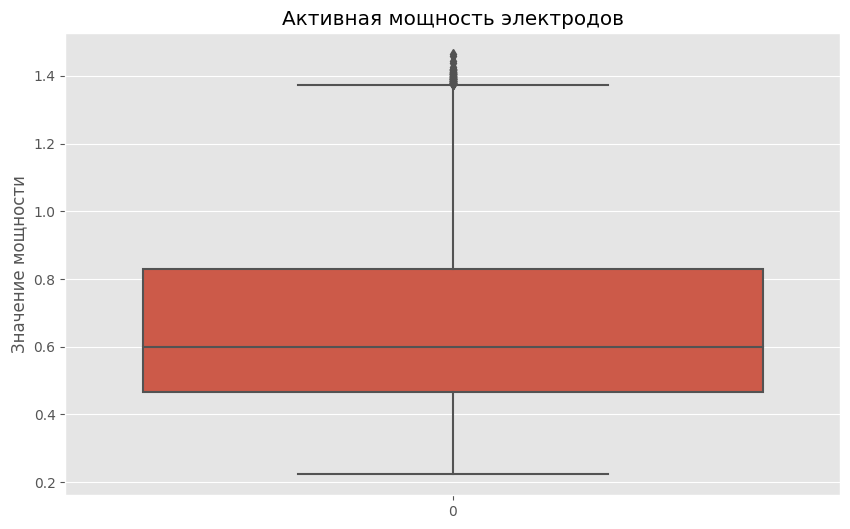

In [14]:
sns.boxplot(electrods['активная_мощность'])
plt.title('Активная мощность электродов')
plt.ylabel('Значение мощности')
plt.show()

На графике присутствуют выбросы, но они находятся близко с линии полуторного квантильного размаха.
Выброс реактивной мощности не позволяет составить график. Это аномальное значение, поэтому мы можем избавиться от него

In [15]:
anomal_idx = electrods['реактивная_мощность'].sort_values().index[0]
electrods = electrods.drop(anomal_idx, axis=0)

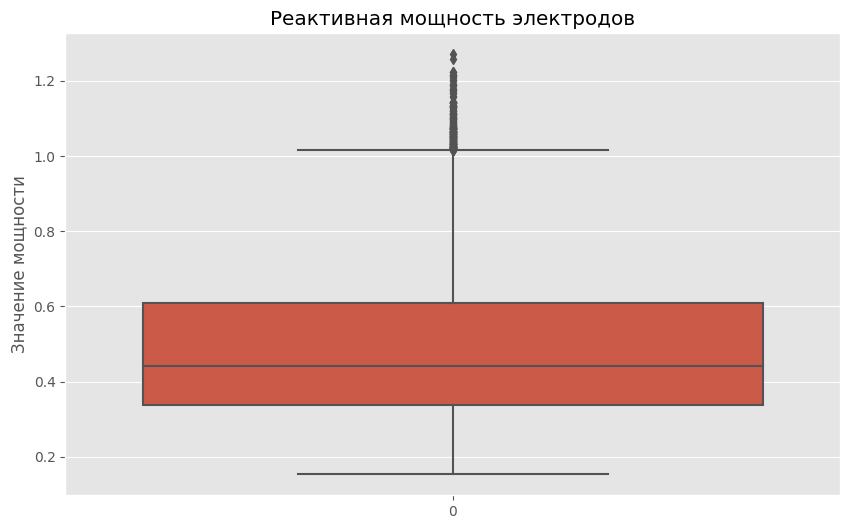

In [16]:
sns.boxplot(electrods['реактивная_мощность'])
plt.title('Реактивная мощность электродов')
plt.ylabel('Значение мощности')
plt.show()

Медианное значение реактивной мощности меньше активной мощности, то же можно сказать и про границы 1.5 размахов. Мы также видим видим выбросы за пределы полуторамежквартильного размаха

Проверим, как распределено число нагревов

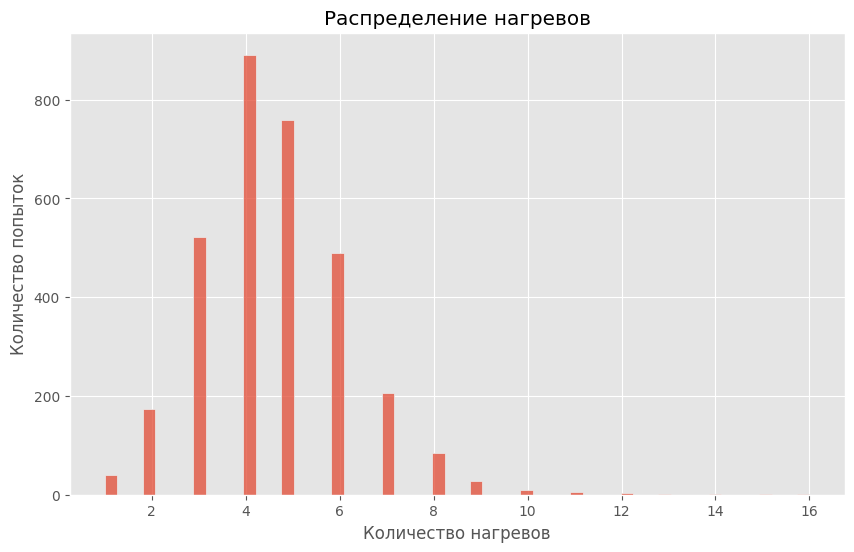

In [17]:
sns.histplot(electrods['key'].value_counts())
plt.title('Распределение нагревов')
plt.xlabel('Количество нагревов')
plt.ylabel('Количество попыток')
plt.show()

Минимальной количество нагревов равно единице. Всего таких попыток было около 50 (50 уникальных ковшей с одним нагревом) Максимальное значение - 16, чаще всего нагревы лежат в пределе от 3 до 6 включительно

In [18]:
#проверка линейной зависимости
electrods[['активная_мощность', 'реактивная_мощность']].corr()

,активная_мощность,реактивная_мощность
активная_мощность,1.000000,0.966373
реактивная_мощность,0.966373,1.000000


Мощности имеют сильную линейную положительную корреляцию между собой

In [19]:
f"Количество уникальный значений ковшей - {electrods['key'].nunique()}"

'Количество уникальный значений ковшей - 3214'

#### Сыпучий материал (объем)

In [20]:
check_dataframe(loose_volume)

Статистические показатели
               key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000

Мы видим количество пропусков, в некоторых столбцах доходящее до 100%

In [21]:
def miss_barplot(data, name):
    """
    :::Функция принимает датафрейм и название для графика
    :::Отражает график
    """
    
    df = data.copy()
    miss_values = pd.DataFrame(df.isna().mean().reset_index())
    miss_values.columns = ['name', 'mean_miss']
    #для отображения в процентах
    miss_values['mean_miss'] = miss_values['mean_miss'] * 100
    miss_values = miss_values[miss_values['name'] != 'key']
    
    sns.barplot(data=miss_values, x='name', y='mean_miss')
    plt.title(f'{name}. Пропущенные значения')
    plt.ylabel('Процент пропущенных значений')
    plt.xlabel('Номер порядковый')
    plt.xticks(rotation=90)
    plt.show()
    

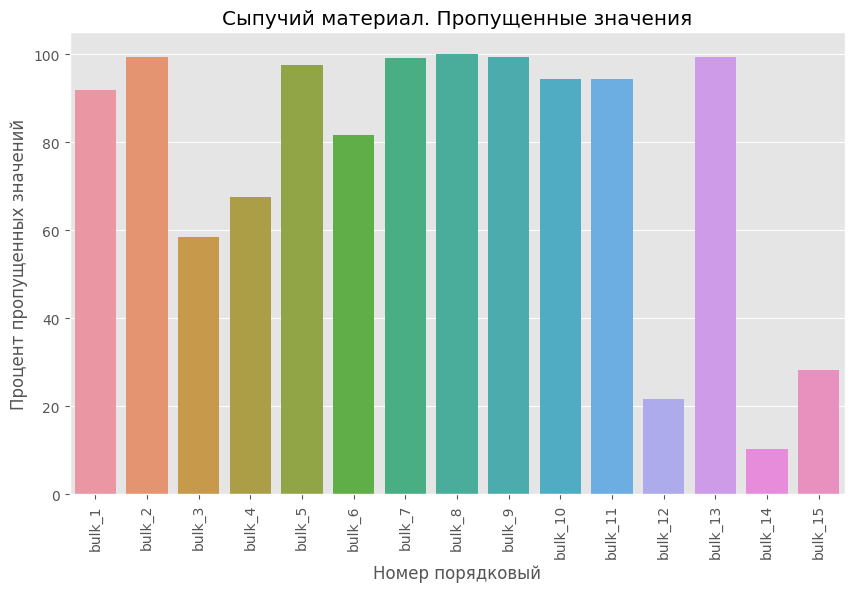

In [22]:
miss_barplot(loose_volume, 'Сыпучий материал')

Наименьшее число пропусков в 12, 14, 15 массах. Посмотрим на диапазон значений

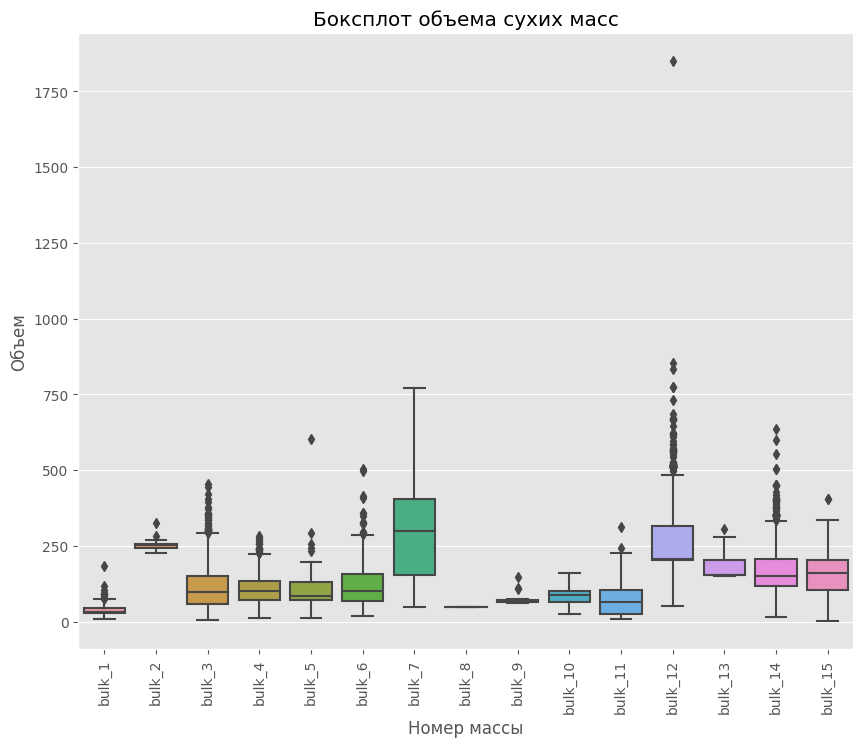

In [23]:
plt.figure(figsize=(10,8))
sns.boxplot(data=loose_volume[loose_volume.columns[1:]])
plt.title('Боксплот объема сухих масс')
plt.ylabel('Объем')
plt.xlabel('Номер массы')
plt.xticks(rotation=90)
plt.show()

Большинство масс обладает выбросами, превышающими верхний 1.5IQR. Также в массе 12 заметна аномалия, которая значительно отличается от всех подобных значений.

In [24]:
loose_volume

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


#### Сыпучий материал(время)

In [25]:
check_dataframe(loose_time)

Статистические показатели
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000
------------------------------------------------------------
------------------------------------------------------------

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   obj

Видим то же большое количество пропусков, где лишь в 12, 14, 15 массах количество пропусков не превышает трети

Потребуется перевести сразу много колонок к типу timestamp

In [26]:
def col_to_timestamp(df):
    
    #функция переводит ячейки в timestamp
    for col in df.columns[1:]:
        #если есть nan, то пропускам значение
        loose_time[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

In [27]:
loose_time = col_to_timestamp(loose_time)

In [28]:
loose_time

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


#### Газ

In [29]:
check_dataframe(gas)

Статистические показатели
               key        газ_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040
------------------------------------------------------------
------------------------------------------------------------

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
------------------------------------------------------------
------------------------------------------------------------

Пропуски в датасете, %
key      0.0
газ_1    0.0
dtype: float64


Поверхностный осмотр говорит нам об отсутствии пропусков, а также об отсутствии анолмаьных значений, по типу отрицательного количества

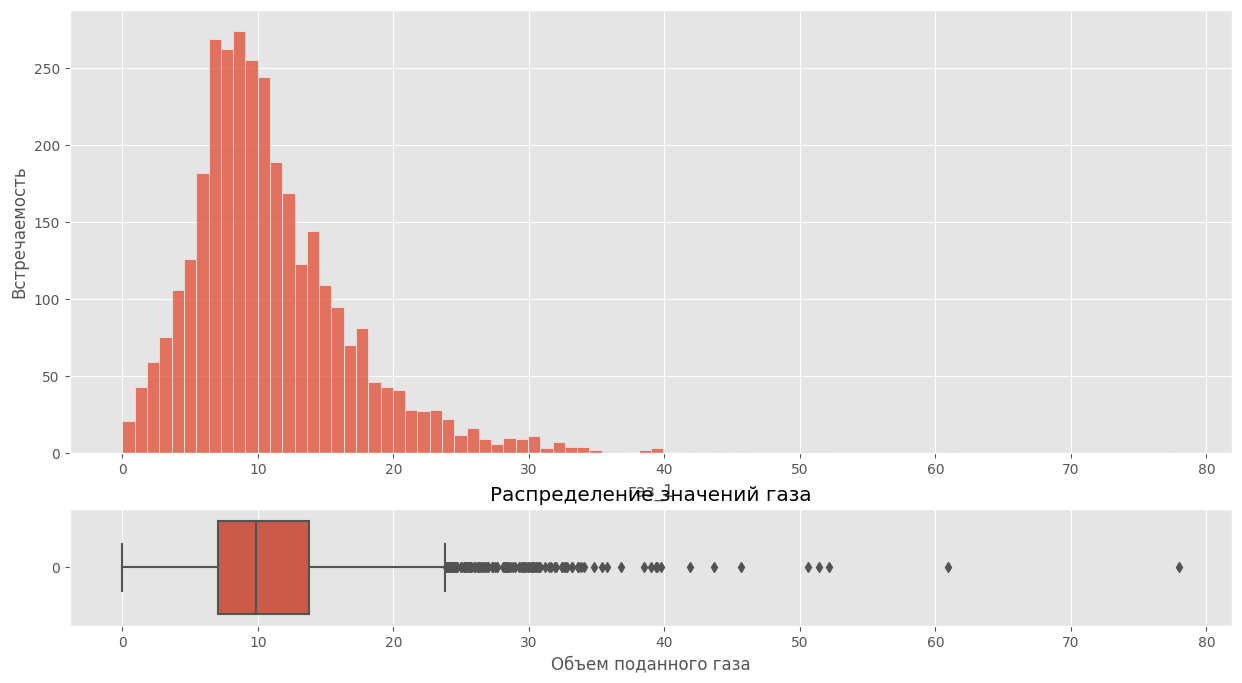

In [30]:
#график по газу
fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(15, 8), gridspec_kw={"height_ratios": (.95, .25)})
sns.histplot(data=gas['газ_1'], ax=ax_hist)
sns.boxplot(gas['газ_1'], ax=ax_box, orient='h')
plt.title('Распределение значений газа')
ax_hist.set(ylabel='Встречаемость')
ax_box.set(xlabel='Объем поданного газа')
plt.show()

Распределение логнормальное, с модой около 10. Хвост тяжелый, что характерно для логнормального распределения: максимальное значения почти достигает 80

#### Температура

In [31]:
check_dataframe(temperature)

Статистические показатели
                key   температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000
------------------------------------------------------------
------------------------------------------------------------

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   время_замера  18092 non-null  object 
 2   температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
------------------------------------------------------------
------------------------------------------------------------

Пропуски

Во времени замеров отсутствуют пропуски, температура пропущена в 20% случаев.

In [32]:
#переведем время в timestamp
temperature['время_замера'] = pd.to_datetime(temperature['время_замера'])

In [33]:
#создадим датафрейм с пропущенными значениями
miss_temperature = temperature[temperature['температура'].isna()==True]

In [34]:
#все ключи с пропусками
miss_key = set(miss_temperature['key'].unique().tolist())

In [35]:
#все ключи без пропусков
not_miss_key = set(temperature.loc[temperature['температура'].isna()!=True, 'key'].tolist())

In [36]:
#проверка на уникальные отстутсвующие ключи
miss_key - not_miss_key

set()

Все ключи с пропусками - неуникальны, то есть ранее по ним были данные по температуре

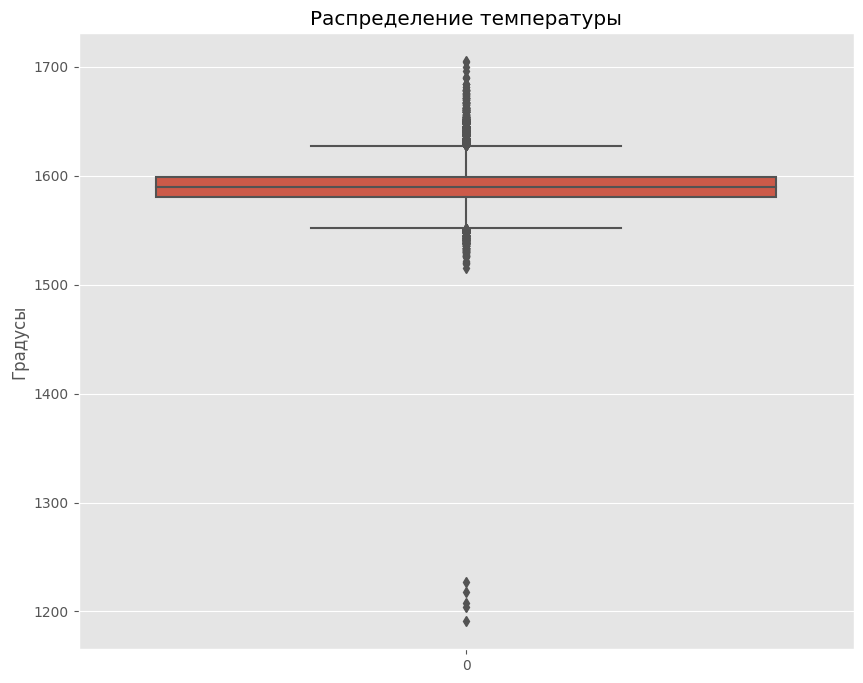

In [37]:
plt.figure(figsize=(10,8))
sns.boxplot(temperature['температура'])
plt.title('Распределение температуры')
plt.ylabel('Градусы')
plt.show()

На графике присутствуют выбросы вне 1.5IQR, но они не отколняются на огромное расстояние, усы находятся на приблизительно схолжем расстоянии от медианыц, что говорит о похожей плотности градусов. Но у нас есть и аномально низкие значения, которые очень далеко отклонены от медианы

#### Проволока(объем)

In [38]:
check_dataframe(wire_volume)

Статистические показатели
               key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           wire_6     wire_7      wire_8     wire_9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076

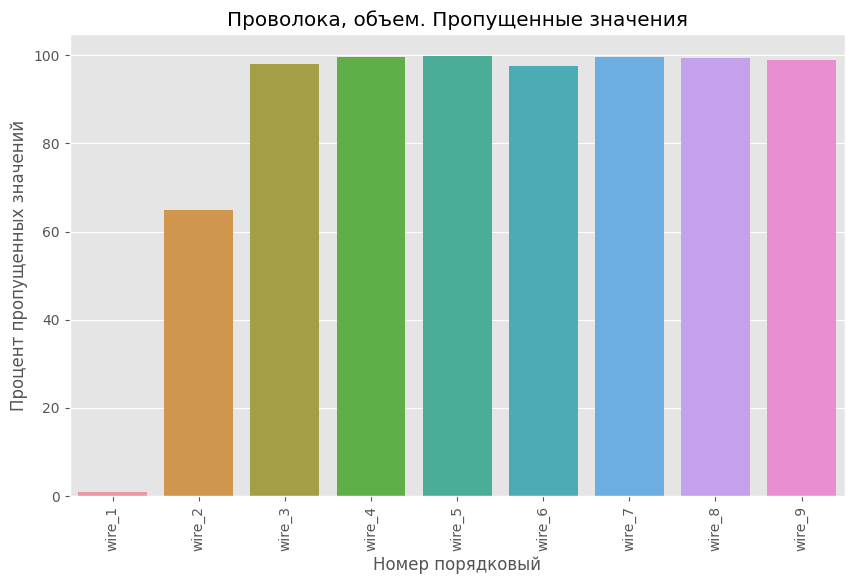

In [39]:
miss_barplot(wire_volume, 'Проволока, объем')

#### Проволока время

In [40]:
wire_volume

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
check_dataframe(wire_time)

Статистические показатели
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
------------------------------------------------------------
------------------------------------------------------------

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
------------------------------------------------------------
-

Схожее с объемом количество пропусков, только wire_1 содержит менее 1% пропусков

In [42]:
wire_time = col_to_timestamp(wire_time)

In [43]:
wire_time

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ПЛАН

1. Необходимо сделать предподготовительный процесс: устранение выбросов (если потребуется), отсутствующих значений, где это возможно. Для разных моделей следует сделать разную предобработку: так для линрега подребуется устранить мультиколлинеарность, а также сделать нормализацию данных (то же относится и к глубокому обучению)
2. Определить, что является таргетом и подобрать соответствующую метрику качества. 
3. Смерджить таблицы в одну (какие потребуется, судя по всему не все таблицы будут нести смысл дле предсказания температуры. Это нтносится, например, к таблицам, которые идут уже после теплообработки), разделить на трейн и тест. 
4. Подобрать наилучшую модель для задачи регрессии. Попробовать модели классического МЛ (линрег, бустинг), так и DL (1D-conv, GRU). Пользоваться кросс-валидацией и оптимизаторами гиперпараметров
5. Провести тестирование результатов на принадлежность к одному распределению. Таким образом, мы сможем установить расхождение между истинным и предсказанным статистическими методами
6. Проверить наилучшую модель на тестовой выборке

### Цель

Предсказание температуры стали, для уменьшение потребления электроэнергии. Таким образом, мы экономим средства компании, оставляя высоким качество продукции

## 2. Предобработка <a class="anchor" id="preprcoc"></a>

### 1. Температура

Выбросами мы посчитали значения температуры около 1200 градусов. Поэтому оставит только те значения, которые находятся ближе к медиане. Отсечкой будет 1300

In [44]:
temperature = temperature.loc[temperature['температура'] > 1300]

In [45]:
temperature

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


Также, температура - наш таргет, а если быть точнее - температура на последнем этапе легования. Поэтому преобразуем таблицу

In [46]:
temp_data = temperature.groupby('key')['время_замера'].agg(['min', 'max', 'count'])

In [47]:
#устраняем те наблюдения, где конеченое время и стартовое не совпадают, то есть где просиходит легование
temp_data = temp_data[temp_data['count'] != 1].reset_index()
temp_data.columns = ['key', 'start', 'finish', 'steps']

In [48]:
#мерджим и забираем начальные температуры
temp_data = temp_data.merge(temperature, how='left', left_on=['key', 'start'], right_on=['key', 'время_замера'])
#мерджим и забираем конечные температуры
temp_data = temp_data.merge(temperature, how='left', left_on=['key', 'finish'], right_on=['key', 'время_замера'])

In [49]:
temp_data

,key,start,finish,steps,время_замера_x,температура_x,время_замера_y,температура_y
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,6,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,5,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,6,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,5,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,5,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,7,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,4,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,6,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0


In [50]:
#как признак можно добавить время легования
temp_data['time_delta'] = (temp_data['finish']-temp_data['start']).dt.total_seconds() / 60

Теперь мы можем оставить только нужные нам колонки: имя ковша, количество этапов легования, начальная и конечная температуры, время легования

In [51]:
temp_data = temp_data.drop(['start', 'finish', 'время_замера_x', 'время_замера_y'], axis=1)
temp_data.columns = ['key', 'steps', 'start_temp', 'finish_temp', 'time_delta']

In [52]:
temp_data

,key,steps,start_temp,finish_temp,time_delta
0,1,6,1571.0,1613.0,28.566667
1,2,5,1581.0,1602.0,21.083333
2,3,6,1596.0,1599.0,29.216667
3,4,5,1601.0,1625.0,20.333333
4,5,5,1576.0,1602.0,25.600000
...,...,...,...,...,...
2470,2495,5,1570.0,1591.0,23.000000
2471,2496,7,1554.0,1591.0,28.416667
2472,2497,4,1571.0,1589.0,16.033333
2473,2498,6,1591.0,1594.0,25.333333


### 2. Мощность

Как мы убедились раньше, активная и реактивная мощность имеют сильную положительную корреляцию, почти близку к единице (линейная зависимость). Поэтому мы оставляем только активную мощность, точнее ее среднее по каждому ковшу.

Мы можем попробовать также определить полную мощность в единицу времени. Полная мощность - это сумма квадратов активной и реактивной мощности.

Также, мы можем попробовать признак работы, то есть проивездения мощности на время процесса. Так мы объединим оба признака в один (мощность и время в работу)

In [53]:
electrods

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [54]:
#полная мощность
electrods['full_power'] = np.sqrt(electrods['активная_мощность'] ** 2 + electrods['реактивная_мощность'] ** 2)
#время работы
electrods['power_diff_time'] = (electrods['конец_нагрева_дугой'] - electrods['начало_нагрева_дугой'])\
                                .dt.total_seconds() / 60
#работа
electrods['work'] = electrods.eval("full_power * power_diff_time")
#аггеригурием по ковшам
power_data = electrods.groupby('key').agg(
                                    {
                                    'реактивная_мощность': 'count',
                                    'work': 'sum',
                                    'активная_мощность':'mean'
                                    }).\
                                    reset_index()

power_data.columns = ['key', 'power_count', 'work',' acive_power']

In [55]:
power_data

,key,power_count,work,acive_power
0,1,5,12.838035,0.607346
1,2,4,8.029333,0.534852
2,3,5,12.047294,0.812728
3,4,4,11.390927,0.676622
4,5,4,8.536166,0.563238
...,...,...,...,...
3209,3237,5,10.508392,0.508374
3210,3238,3,4.767538,0.458274
3211,3239,8,15.692313,0.606001
3212,3240,5,10.957331,0.663536


### 3. Добавление присадок и проволоки

Налиичие пропуска в присадках и проволоках говорит о том, что они не подавались. При изучении таблиц было установлено, что в присадках столбец с минимальным числом пропусков - 14 (количество пропусков - 10%). Таким образом, пропуск будет заменен на 0.

In [56]:
lv_data = loose_volume.fillna(0)
#вычисляем сумму и среднее присадок по ковшу
lv_data.loc[:, 'sum_bulk'] = lv_data.iloc[:, 2:].sum(axis=1)
lv_data.loc[:, 'avg_bulk'] = lv_data.iloc[:, 2:-1].mean(axis=1)

In [57]:
#Как дополнительный прзинак мы можем добавить использование редких присадок, то есть присадок вне 12, 14 и 15
#cols = [f'bulk_{i}' for i in range(1, 14) if i not in [12,14,15]]
#lv_data['rare_bulk'] = lv_data[cols].any(axis=1, bool_only=False).replace({True: 1, False: 0})

In [58]:
lv_data

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk,avg_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,39.500000
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,41.571429
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,38.857143
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,42.500000
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,41.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,54.142857
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,42.428571
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,45.000000
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0,19.428571


In [59]:
#Оставим только key и два последних столбца
#lv_data = lv_data[['key', 'avg_bulk']]

Проделаем схожие операции с проволокой. Только первый wire почти не содержит пропусков

In [60]:
wire_data = wire_volume.fillna(0)
wire_data['sum_wire'] = wire_data.iloc[:, 1:].sum(axis=1)
wire_data['avg_wire'] = wire_data.iloc[:, 1:-1].mean(axis=1)
#wire_data['rare_wire'] = wire_data.iloc[:, 3:-2].any(axis=1).replace({True: 1, False: 0})
#wire_data = wire_data[['key', 'avg_wire']]

In [61]:
wire_data

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,avg_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,6.673333
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,10.672479
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,10.128906
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,9.895946
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,10.928088
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959,4.232107
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799,6.236533
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761,15.928640
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400,3.785600


### 4.  Объединение таблиц

Объединять таблицы будем по ключу key и только по тем записям, которые есть в таблицах. Таблицы time по wire и bulk использовать не будем

In [62]:
#температура и мощность
full_data = temp_data.merge(power_data, how='left', left_on='key', right_on='key')
#газ
full_data = full_data.merge(gas, how='left', left_on='key', right_on='key')
#bulk
full_data = full_data.merge(lv_data, how='left', left_on='key', right_on='key')
#wire
full_data = full_data.merge(wire_data, how='left', left_on='key', right_on='key')

In [63]:
full_data = full_data.rename(columns={'газ_1':'gas'})

In [64]:
full_data

,key,steps,start_temp,finish_temp,time_delta,power_count,work,acive_power,gas,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,avg_wire
0,1,6,1571.0,1613.0,28.566667,5,12.838035,0.607346,29.749986,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,6.673333
1,2,5,1581.0,1602.0,21.083333,4,8.029333,0.534852,12.555561,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,10.672479
2,3,6,1596.0,1599.0,29.216667,5,12.047294,0.812728,28.554793,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,10.128906
3,4,5,1601.0,1625.0,20.333333,4,11.390927,0.676622,18.841219,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,9.895946
4,5,5,1576.0,1602.0,25.600000,4,8.536166,0.563238,5.413692,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,10.928088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,5,1570.0,1591.0,23.000000,4,11.569622,0.792033,7.125735,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,9.905653
2471,2496,7,1554.0,1591.0,28.416667,6,13.596976,0.695820,9.412616,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,12.686614
2472,2497,4,1571.0,1589.0,16.033333,3,13.717009,1.201746,6.271699,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,11.459414
2473,2498,6,1591.0,1594.0,25.333333,5,9.696846,0.640462,14.953657,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,13.123413


In [65]:
#проверка на пропуски
full_data.isna().sum()

key               0
steps             0
start_temp        0
finish_temp       0
time_delta        0
power_count       0
work              0
 acive_power      0
gas               2
bulk_1           68
bulk_2           68
bulk_3           68
bulk_4           68
bulk_5           68
bulk_6           68
bulk_7           68
bulk_8           68
bulk_9           68
bulk_10          68
bulk_11          68
bulk_12          68
bulk_13          68
bulk_14          68
bulk_15          68
sum_bulk         68
avg_bulk         68
wire_1          103
wire_2          103
wire_3          103
wire_4          103
wire_5          103
wire_6          103
wire_7          103
wire_8          103
wire_9          103
sum_wire        103
avg_wire        103
dtype: int64

In [66]:
#проверка
full_data[full_data['avg_wire'].isna()==True]

,key,steps,start_temp,finish_temp,time_delta,power_count,work,acive_power,gas,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,avg_wire
48,51,5,1619.0,1690.0,30.266667,4,13.788892,0.585349,9.236758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,52,7,1617.0,1669.0,42.483333,6,17.879167,0.691929,14.119615,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,53,5,1642.0,1671.0,31.416667,4,19.877626,0.784729,7.090307,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,54,5,1630.0,1663.0,32.783333,4,10.925851,0.627417,5.547380,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,55,5,1615.0,1654.0,31.200000,4,16.007237,0.732456,8.915683,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,2389,5,1653.0,1646.0,22.366667,4,7.290718,0.602082,6.488502,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2368,2390,3,1679.0,1648.0,20.833333,2,3.015457,0.769282,1.757037,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2369,2391,6,1623.0,1644.0,26.966667,5,10.299071,0.565868,7.114327,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2370,2392,4,1623.0,1650.0,20.016667,3,6.100445,0.347954,6.946684,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ковш 51 прошел 5 этапов замерки температуры, то есть в процессе легования к нему должны были добавлять присадки и проволоку, иначе это было бы лишено смысла - просто подогревать материал с хорошим хим составом. На этом основании, мы делаем вывод о том, что данные не были нами дополучены. Значит, мы можем попробовать убрать данные с пропусками.

In [67]:
full_data = full_data.dropna(axis=0)

In [68]:
full_data

,key,steps,start_temp,finish_temp,time_delta,power_count,work,acive_power,gas,bulk_1,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,avg_wire
0,1,6,1571.0,1613.0,28.566667,5,12.838035,0.607346,29.749986,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,6.673333
1,2,5,1581.0,1602.0,21.083333,4,8.029333,0.534852,12.555561,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,10.672479
2,3,6,1596.0,1599.0,29.216667,5,12.047294,0.812728,28.554793,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,10.128906
3,4,5,1601.0,1625.0,20.333333,4,11.390927,0.676622,18.841219,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,9.895946
4,5,5,1576.0,1602.0,25.600000,4,8.536166,0.563238,5.413692,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,10.928088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,5,1570.0,1591.0,23.000000,4,11.569622,0.792033,7.125735,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,9.905653
2471,2496,7,1554.0,1591.0,28.416667,6,13.596976,0.695820,9.412616,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,12.686614
2472,2497,4,1571.0,1589.0,16.033333,3,13.717009,1.201746,6.271699,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,11.459414
2473,2498,6,1591.0,1594.0,25.333333,5,9.696846,0.640462,14.953657,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,13.123413


После объединения таблиц проверим данные на возможную мультиколлинеарность. Не все наши значения не обладают нормальным распределением, поэтому воспользуемся ранговой корреляцией Спирмана

In [69]:
#мы не будем отражать данные колонки на тепловой карте
unskip_columns = [col for col in full_data.columns if not col.startswith('bulk_') | col.startswith('wire_')]

interval columns not set, guessing: ['key', 'steps', 'start_temp', 'finish_temp', 'time_delta', 'power_count', 'work', ' acive_power', 'gas', 'sum_bulk', 'avg_bulk', 'sum_wire', 'avg_wire']


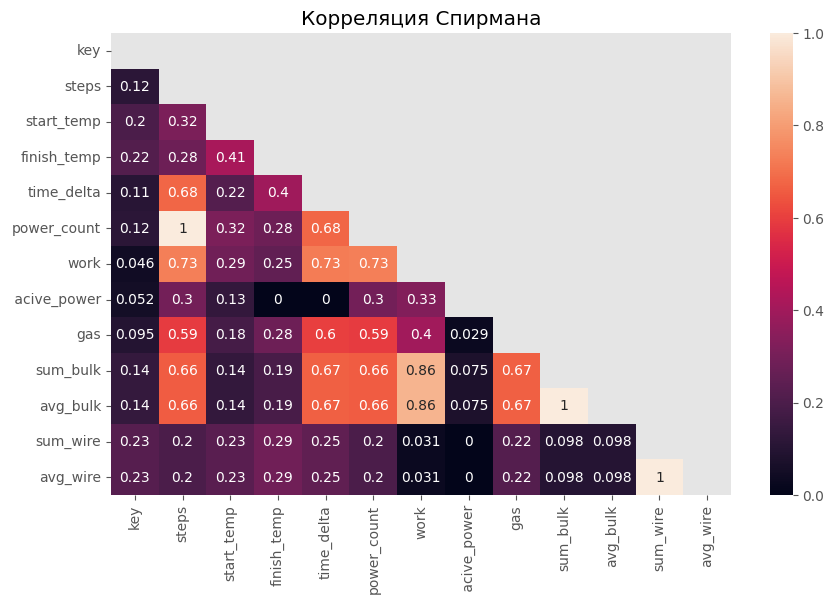

In [70]:
corr = full_data[unskip_columns].phik_matrix()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, annot=True)
plt.title('Корреляция Спирмана')
plt.show()

У нас есть признаки с сильной зависимостью: от 0.7. Причина этого ясна: чем дольше проходит какой-то процесс, тем сильнее будут расти объемы присадок, проволоки, время процедуры, число этапов. Для линейной модели мультиколлинеарность (наличие линейной зависимости между признаками, которые не вносят дополнительной инофрмации, усложняют расчеты, приводят к переобучению, в вследствие чего модель не робастна, и результаты на новых данных будут далеки от реальных). Время работы электродов (power_diff_time) не несет дополнительной инофрмации. Поэтому можно будет убрать этот признак для модели линейной регрессии

Также наши данные имеют разный масштаб значений. Поэтому необходимо провести стандартизацию данных для моделей, которые этого требуют: линейные и модели глубокого обучения

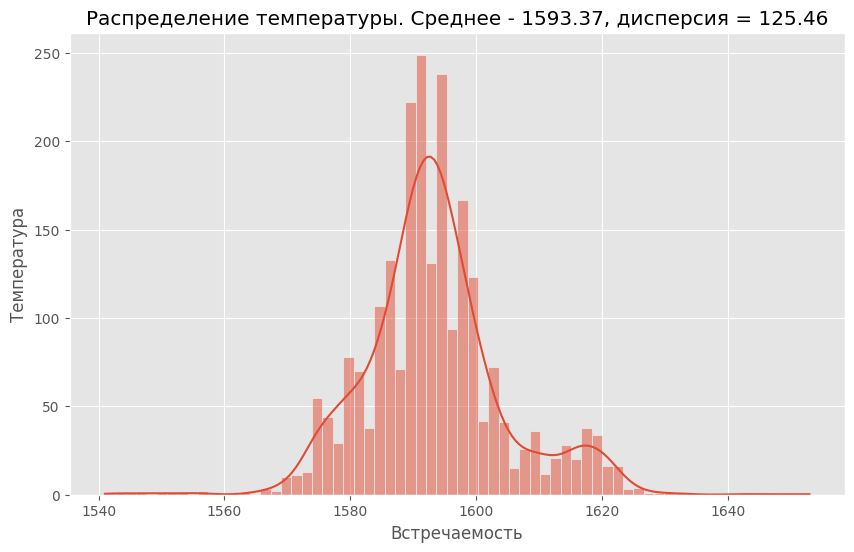

In [71]:
#проверка распределения целевого признака
mean = round(full_data['finish_temp'].mean(), 2)
var = round(full_data['finish_temp'].std() ** 2, 2)
sns.histplot(data=full_data['finish_temp'], kde=True)
plt.title(f'Распределение температуры. Среднее - {mean}, дисперсия = {var}')
plt.xlabel('Встречаемость')
plt.ylabel('Температура')
plt.show()

Распределение целевого признака близко к нормальному, нам не потребуется проводить дополнительные операции преобразования

In [72]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, train_test_split

In [73]:
def train_test_frames(data, target_name, normalize, for_drop=[]):
    
    """
    :::Функция принимает датафрейм, имя целевого признака и булево значение номрализации
    :::Возвращает трейн и тест наборы
    """
    
    df = data.copy()
    X, y = df.drop(target_name, axis=1), df[target_name]
    
    if for_drop:
        X = X.drop(for_drop, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=RS, test_size=0.25)
    
    if normalize:
        sc = StandardScaler()
        X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [74]:
#два набора данных, с и без нормализации
X_train_norm, X_test_norm, y_train, y_test = train_test_frames(full_data.drop(['key'], axis=1), 
                                                               'finish_temp', normalize=True,
                                                              for_drop=['steps', 'sum_bulk', 'avg_bulk'])
X_train, X_test, y_train, y_test = train_test_frames(full_data.drop(['key'], axis=1), 
                                                     'finish_temp', normalize=False, 
                                                     for_drop=['steps', 'sum_bulk', 'avg_bulk'])

## 3. Моделирование <a class="anchor" id="modelling"></a>

### 3.1 Dummy <a class="anchor" id="dummy"></a>

Необходимо понять, какого результата мы добъемся используя обычную дамми-моедль, предсказывающую просто среднее значение

In [75]:
#словарь для сбора метрик
mae_dict = {}

In [76]:
#простая дамми-модель
y_pred_dummy = np.array([y_train.mean()] * y_train.shape[0])
mae_dict['dummy'] = mae(y_train, y_pred_dummy)
f'Dummy - {np.round(mae(y_train, y_pred_dummy), 2)}'


'Dummy - 7.98'

Дамми модель, предсказыввающая средние значение на ~ 1.3 превышает требуемый порог в 6.8

### 3.2 LinearRegression<a class="anchor" id="linreg"></a>

В качестве линейно модели будет использоваться регрессия с L2-регуляризацией. В данном случае наименее важные параметры поулчат наименьшй вес

In [77]:
def ridge_regression(X_train, y_train, n_trials=10):
    
    def objective(trial):
        
        params = {
            'alpha' : trial.suggest_float('alpha', 0.2, 30, step=0.2),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag', 'lsqr', 'saga']),
            'max_iter': trial.suggest_int('max_iter', 500, 2000, step=10)
        }
        
        if params['solver'] == 'lbfgs':
            params['positive'] = True
        model = Ridge(**params, random_state=RS)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=RS)
        score = cross_val_score(model, X_train, y_train, cv=cv, 
                                n_jobs=-1, error_score='raise', 
                                scoring='neg_mean_absolute_error')
        return -np.mean(score)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

In [78]:
ridge_model = ridge_regression(X_train, y_train, n_trials=100)

[I 2023-05-01 22:33:04,434] A new study created in memory with name: no-name-7a7138e6-91c3-42e3-9225-f4f64542fda1
[I 2023-05-01 22:33:04,556] Trial 0 finished with value: 6.4038058529576904 and parameters: {'alpha': 8.799999999999999, 'solver': 'lsqr', 'max_iter': 1750}. Best is trial 0 with value: 6.4038058529576904.
[I 2023-05-01 22:33:04,659] Trial 1 finished with value: 6.511227980585791 and parameters: {'alpha': 21.6, 'solver': 'lsqr', 'max_iter': 700}. Best is trial 0 with value: 6.4038058529576904.
[I 2023-05-01 22:33:04,680] Trial 2 finished with value: 6.566394122797073 and parameters: {'alpha': 22.2, 'solver': 'lsqr', 'max_iter': 970}. Best is trial 0 with value: 6.4038058529576904.
[I 2023-05-01 22:33:04,699] Trial 3 finished with value: 6.959274855119466 and parameters: {'alpha': 1.2, 'solver': 'lbfgs', 'max_iter': 1470}. Best is trial 0 with value: 6.4038058529576904.
[I 2023-05-01 22:33:05,241] Trial 4 finished with value: 6.586491850040906 and parameters: {'alpha': 15.4,

In [79]:
ridge_model.best_trials

[FrozenTrial(number=24, values=[6.342544241234171], datetime_start=datetime.datetime(2023, 5, 1, 22, 33, 8, 891579), datetime_complete=datetime.datetime(2023, 5, 1, 22, 33, 8, 916578), params={'alpha': 4.0, 'solver': 'lsqr', 'max_iter': 1550}, distributions={'alpha': FloatDistribution(high=30.0, log=False, low=0.2, step=0.2), 'solver': CategoricalDistribution(choices=('lbfgs', 'sag', 'lsqr', 'saga')), 'max_iter': IntDistribution(high=2000, log=False, low=500, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=24, state=TrialState.COMPLETE, value=None)]

In [80]:
mae_dict['Ridge'] = ridge_model.best_trials[0].values[0]
f"Среднее по кросс-валидации модели Ridge - {np.round(mae_dict.get('Ridge'), 2)}"

'Среднее по кросс-валидации модели Ridge - 6.34'

Лучшее значение меньше 6.4, что превосходит дамми-модель

In [81]:
#лучшие параметры по линейном моделе
ridge_params = ridge_model.best_trials[0].params
lin_model = Ridge(**ridge_params, random_state=RS).fit(X_train, y_train)

In [82]:
#функция для табличного отражения важности признаков
def feat_importance(coeff):

    coef = pd.DataFrame(data={
        'name' : X_train.columns,
        'coefficient' : coeff
    })
    
    coef = coef.sort_values('coefficient')
    
    return coef

In [83]:
#оценим влияние признаков
lin_coef = feat_importance(lin_model.coef_)

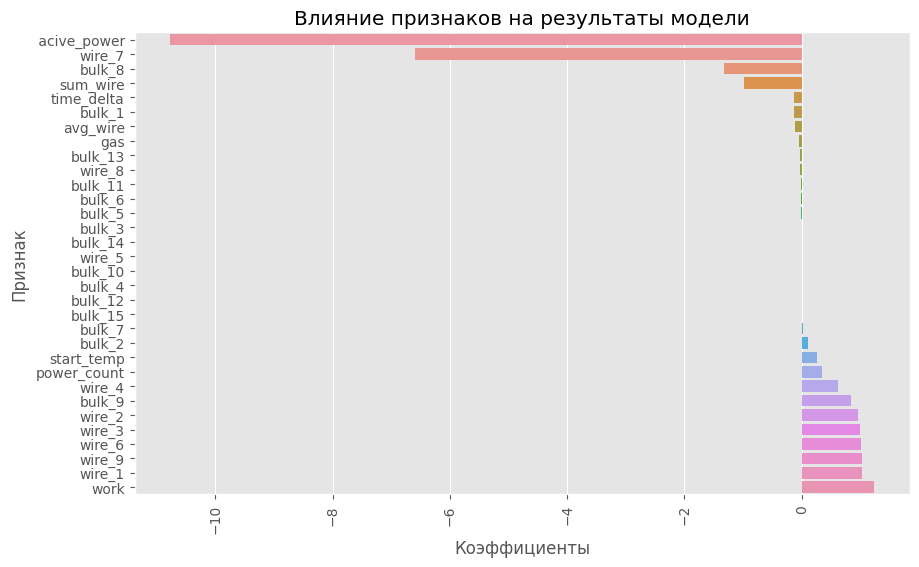

In [84]:
#отрисовка
sns.barplot(data=lin_coef, y='name', x='coefficient')
plt.title('Влияние признаков на результаты модели')
plt.xlabel('Коэффициенты')
plt.ylabel('Признак')
plt.xticks(rotation=90)
plt.show()

Сильнее всего на модель влияют следующие признаки:
- На увеличение таргета влияет работа, добавление проволоки, стартовая температура
- На уменьшение таргета значительное влияние оказывает активная мощность, добавление проволоки 7, а также ее суммарное добавление

### 3.3 RandomForest<a class="anchor" id="forest"></a>

In [85]:
#функция случайного леса
def rfr(X_train, y_train, n_trials=10):
    
    def objective(trial):
        
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 8, step=1),
            'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        }
        

        model = RandomForestRegressor(**params, random_state=RS, n_jobs=-1)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=RS)
        score = cross_val_score(model, X_train, y_train, cv=cv, 
                                n_jobs=-1, error_score='raise', 
                                scoring='neg_mean_absolute_error')
        return -np.mean(score)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

In [86]:
#закомменчена дял экономи времени
#forest = rfr(X_train, y_train, n_trials=30)

In [87]:
#forest.best_trials[0].values[0] - лучшее среднее по выборкам

In [88]:
mae_dict['Forest'] = np.round(6.712724708039277, 2)
f"Среднее по кросс-валидации модели Forest - {np.round(mae_dict.get('Forest'), 2)}"

'Среднее по кросс-валидации модели Forest - 6.71'

Лес только немного опустился ниже требуемого значения

In [89]:
#оценим важные признаки
forest_params = {'n_estimators': 2000, 'max_depth': 8, 'max_features': 'sqrt'}
forest_reg = RandomForestRegressor(**forest_params, random_state=RS, n_jobs=-1).fit(X_train, y_train)
rfr_coef = feat_importance(forest_reg.feature_importances_)

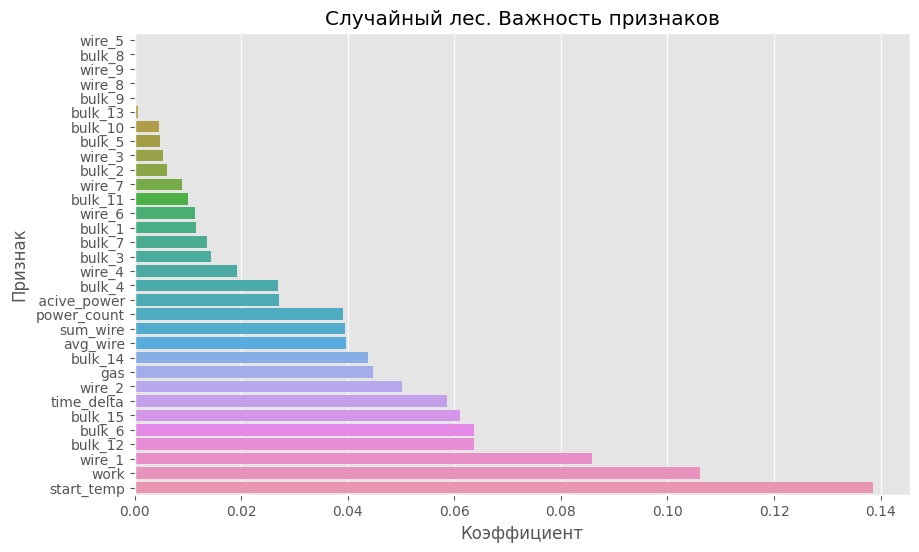

In [90]:
sns.barplot(data=rfr_coef, x='coefficient', y='name')
plt.title('Случайный лес. Важность признаков')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.show()

Лес посчитал начальную температуру, работу, добавление проволоки 1, примеси 12 и время нагрева как самые важные признаки

### 4.4 Catboost<a class="anchor" id="catboost"></a>

In [91]:
def catboost_regression(X_train, y_train, n_trials=10):
    
    def objective(trial):
        
        
        params = {
            'iterations': trial.suggest_int('iterations', 1000, 3000, step=30),
            'max_depth': trial.suggest_int('max_depth', 5, 8, step=1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 20, step=0.2),
            'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.1, step=0.005),
            'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.6, 1.0, step=0.1),
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 50, step=2)
        }
        

        model = catboost.CatBoostRegressor(**params, random_state=RS, verbose=200)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=RS)
        score = cross_val_score(model, X_train, y_train, cv=cv, 
                                n_jobs=-1, error_score='raise', 
                                scoring='neg_mean_absolute_error')
        return -np.mean(score)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

In [92]:
#закомменчена для экономии времени
#cboost_model = catboost_regression(X_train, y_train, n_trials=10)

In [93]:
#cboost_model.best_trials[0].values[0] 

In [94]:
#заносим в словарь
mae_dict['Catboost'] = np.round(6.172735224243967, 2)
f"Среднее по кросс-валидации модели Catbbost - {np.round(mae_dict.get('Catboost'), 2)}"

'Среднее по кросс-валидации модели Catbbost - 6.17'

Значение улучшилось по сравнению с обычной линейной регрессией и случайным лесом. 

In [95]:
cboost_params = {'iterations': 1870, 'max_depth': 6, 
                        'l2_leaf_reg': 18.7, 'learning_rate': 0.028, 
                        'colsample_bylevel': 0.9, 'min_data_in_leaf': 42}

catboost_model= catboost.CatBoostRegressor(**cboost_params, random_state=RS, verbose=200).fit(X_train, y_train)

0:	learn: 10.9896548	total: 141ms	remaining: 4m 23s
200:	learn: 8.5057090	total: 615ms	remaining: 5.1s
400:	learn: 8.0000056	total: 1.12s	remaining: 4.1s
600:	learn: 7.2315876	total: 1.59s	remaining: 3.37s
800:	learn: 6.5976169	total: 2.09s	remaining: 2.79s
1000:	learn: 6.1937565	total: 2.57s	remaining: 2.23s
1200:	learn: 5.8236229	total: 3.08s	remaining: 1.71s
1400:	learn: 5.5494441	total: 3.56s	remaining: 1.19s
1600:	learn: 5.2859701	total: 4.05s	remaining: 680ms
1800:	learn: 5.0872530	total: 4.53s	remaining: 173ms
1869:	learn: 5.0063803	total: 4.69s	remaining: 0us


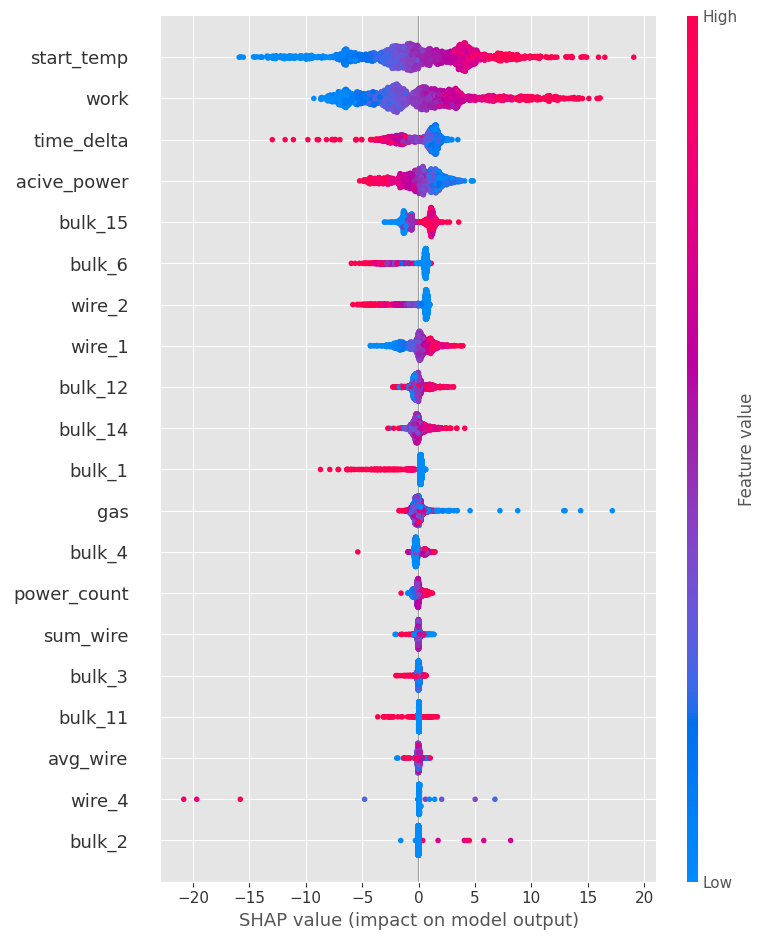

In [96]:
#оценим, какие признаки наиболее важны по мнению бустинга
explain = shap.TreeExplainer(catboost_model)
shap_values = explain.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Бустинг посчитал работу, стартовую температуру наиболее важными признаками, которые калибруют модель в обе стороны. Также к важным признакам относятся время нагрева, активная мощность и некоторые из добавок

Сравним модели между собой и определим наилучшую

In [97]:
#приведение в табличный вид
results = pd.DataFrame(data={
    'model' : mae_dict.keys(),
    'loss' : mae_dict.values()
})

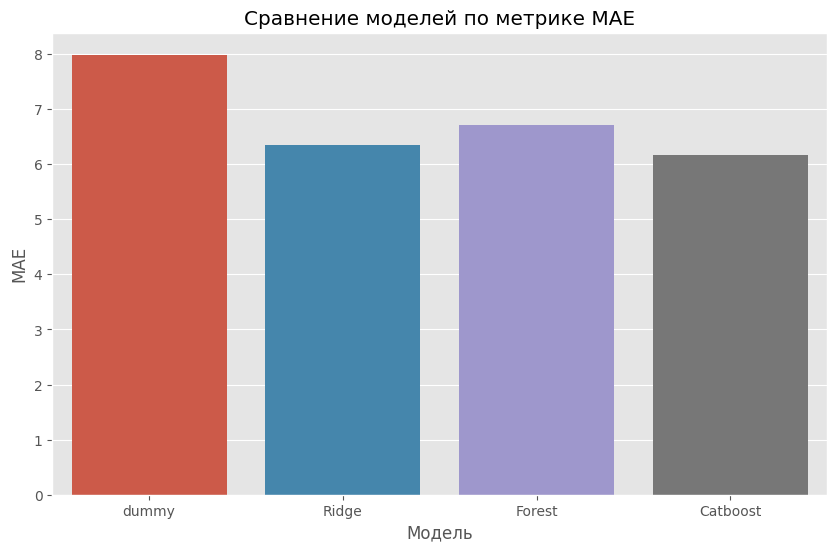

In [98]:
#отрисовка
sns.barplot(results, x='model', y='loss')
plt.title('Сравнение моделей по метрике MAE')
plt.xlabel('Модель')
plt.ylabel('MAE')
plt.show()

Наилучшая модель - Catboost, именно его мы будем использовать на тесте

## Тест <a class="anchor" id="test"></a>

In [99]:
y_prediction = catboost_model.predict(X_test)
test_result = mae(y_test, y_prediction)
f'Значение метрики модели Catboost на тесте - {np.round(test_result, 2)}'

'Значение метрики модели Catboost на тесте - 6.31'

Значение на тесте ниже требуемого, абсолютная ошибка приблизительно равна 6 градусам. 
Модель градиентного бустинга показала, что наиболее важными признаками являются:
- Работа
- Стартовая температура металла
- Время нагрева металла
- Активная мощность электродов

Данные параметры являются наиболее важными для предсказания правильной температуры. Также для определения температуры важны примеси и проволока, но они оказывают меньшее влияние на результаты. В тоже время газ практически не оказывает влияния. 

Также все модели отметили работу как один из самых важных признаков

## 4. Отчет <a class="anchor" id="report"></a>

В процессе подготовки к моделированию, мы выполнили следующие этапы плана:
- Устранили аномалии в данных, которые могли бы исказить финальную модель. 
- Устранили мультиколлинеарные признаки, которые не несли дополнительной информации, а только усложняли бы модель
- Устранили пропуски путем их удаления
- Определились с метрикой качества (MAE) как с наиболее подходящей для данного предсказания
- Обучили несколько моделей и выбрали лучшую путем перебора гиперпараметров через байесовский оптимизатор и кросс-валидацию

Что не сделали:
- Процесс нормализации данных приводил к худшим результатам в каждой подобранной нами модели
- От идеи глубокого обучения было принятно решение отказаться: данных слишком мало, поэтому нейросеть с пятью скрытыми слоями не могла достичь приемлимой оценки, хотя время обучения значительно выше времени обучения классических моделей

Среди трудностей следует отметить сам характер полученных данных: данные отсутствутют, потому что отсутствуют или потому что не было замера, или возникли сложности с замером? Также следует отметить, что для приемлимой модели пришлось прибегнуть к feature-engeenering'у, т.к. изначальные данные не располагали необходимым количеством информации

Ключевыми шагами был момент обработки каждой таблицы, устранение аномалий, правильное слияние таблиц, генерация дополнительных признаков

Итоговая модель - <b>catboost с MAE ~ 6.3</b>

Наиболее важные параметры для модели: 
- начальная температура
- работа
- время добавление примесей
- активная мощность

Начальная температура - мы используем только ту температуру, которая была замерена в самом начале процесса термообработки. Были отброшенны все значения ниже 1300 как аномальные

Работа - корень квадратных сумм мощностей помноженный на время. Данные получены после предобработки таблицы по электродам

Время добавления примесей - время, затраченное на доведение сплава до нужного химсостава путем добавления присадок и проволоки

Активная мощность - активная мощность работы электродов

Гиперпараметры модели: 

- iterations - 870 (число деревьев в бустинге)
- max_depth-  6 (глубина дерева)
- l2_leaf_reg - 18.7 (l2-регуляризация, которая уменьшает вес неважных признаков)
- learning_rate - 0.028  (величина шага градиентного спуска)
- colsample_bylevel - 0.9 (доля от общего числа признаков, которое будет использоваться в каждом дереве) 
- min_data_in_leaf - 42 (мнимальное число наблюдений, чтобы получить лист)
- random_seed - 240423 (случайное начальное значение, инициализирующее случайные веса в начале вычислений)

Построим графики для наглядного представления

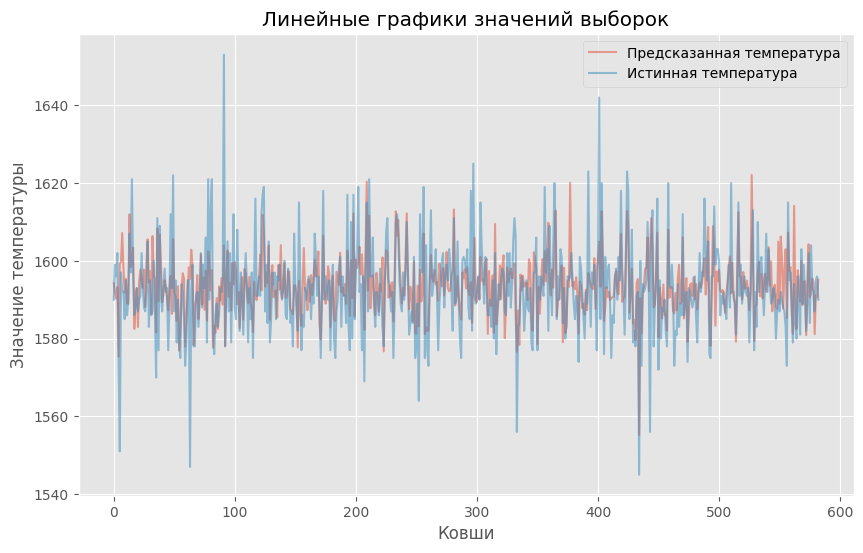

In [100]:
#Графики
sns.lineplot(x = np.arange(y_test.shape[0]), 
             y = y_prediction, 
             label='Предсказанная температура', alpha=0.5)
sns.lineplot(x = np.arange(y_test.shape[0]), 
             y = y_test, 
             label='Истинная температура',  alpha=0.5)
plt.title('Линейные графики значений выборок')
plt.xlabel('Ковши')
plt.ylabel('Значение температуры')
plt.legend()
plt.show()

Истинное значение температуры имеет некоторые всплекски, котоыре модель не смогла уловить. Но модель достаточно хорошо аппроксимирует остальные значения

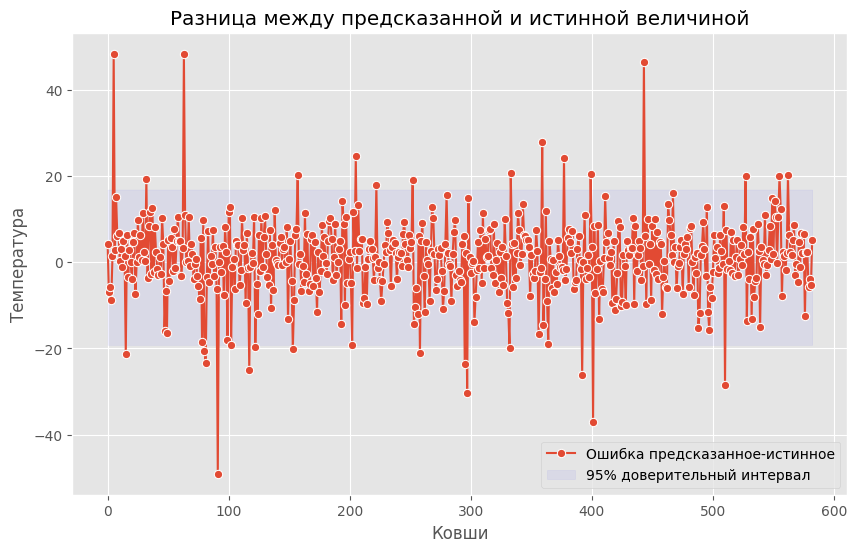

In [101]:
#дифф температур
sns.lineplot(x=np.arange(y_test.shape[0]),
             y=y_prediction - y_test, 
             label='Ошибка предсказанное-истинное',
            marker='o')
plt.fill_between(x=np.arange(y_test.shape[0]),
                y1=(y_prediction - y_test).quantile(0.025),
                y2 = (y_prediction - y_test).quantile(0.975),
                alpha=0.05, color='blue', 
                 label='95% доверительный интервал')
plt.title('Разница между предсказанной и истинной величиной')
plt.xlabel('Ковши')
plt.ylabel('Температура')
plt.legend()
plt.show()

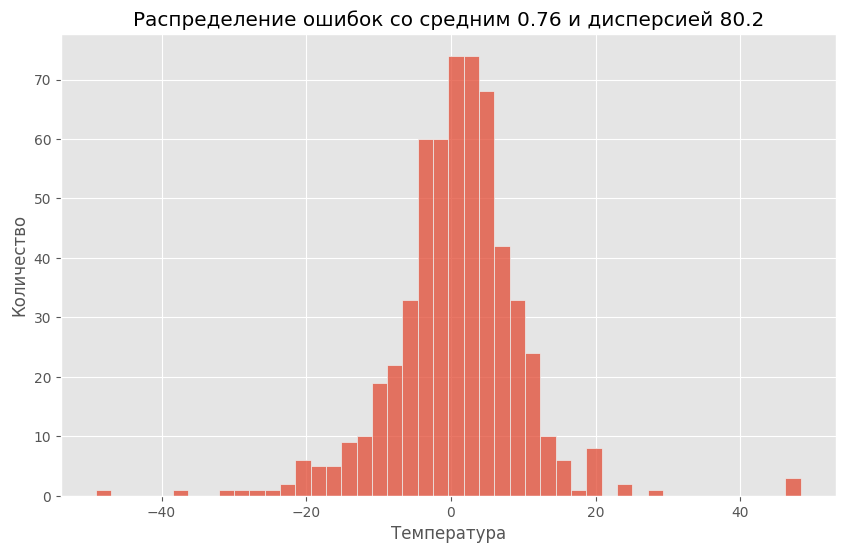

In [102]:
mean_value = np.round((y_prediction - y_test).mean(), 2)
var_value = np.round((y_prediction - y_test).std() ** 2, 2)
sns.histplot(y_prediction - y_test)
plt.title(f'Распределение ошибок со средним {mean_value} и дисперсией {var_value}')
plt.xlabel('Температура')
plt.ylabel('Количество')
plt.show()

Мы имеем достаточно большую дисперсию ошибки, в то же время мы видим, что в 95% доверительном интервале находятся ошибки с куда меньшим разбросом: от -20 до 18.
Проверим, являются ли предсказанное и истинное наблюдения элементами одной выборки

In [105]:
def bootstrap(y_pred, y_true, n=10, pvalue=0.05):
    """
    :::Функция принимает два массива, количество итерация бутстрапа и допустимый порог
    :::Возвращает значение вероятности принадлежности к одному распределению"""
    
    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)
    pred = []
    true = []
    
    for _ in range(n):
        pred.append(y_pred.sample(frac=0.3, replace=True).mean())
        true.append(y_pred.sample(frac=0.3, replace=True).mean())
    
    ttest = ttest_ind(pred, true, equal_var=False)[-1]
    if ttest >= pvalue:
        print('Обе выборки принадлежат одному и тому же распределению')
    else:
        print('Выборки принадлежат разным распределениям')
    
    return f'Принадлежность к одной выборке - {np.round(ttest, 2)}'

In [106]:
bootstrap(y_prediction, y_test, n=20000)

Обе выборки принадлежат одному и тому же распределению


'Принадлежность к одной выборке - 0.28'

Обе выборки принадлежат одному и тому же распределению, значит модель приблизительно хорошо аппроксимировала данные

Для улучшения модели требуется лучшая работа с аномальными значениями, необходимо строго установить допустимую температуру, провести дополнительное исследование, чтобы установить, какие данные, помимо предоставленных, смогут лучше описать дисперсию температур, позволить моделе быть устойчивой и в то же время видеть те признаки, по которым температура может возрасти вне рамок нашего установленного 95% доверительного интервала

В целом, модель достаточно устойчива к выбросам, хотя она не улавливает резкие отклонения в производственном процессе, а старается усреднить температуры, не сильно отклоняясь от среднего